In [2]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from genre_recommender import preprocess_popularity, recommend_top_movies_by_genres, show_recommendations, get_all_genres
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy.sparse import csr_matrix
import implicit
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.decomposition import NMF, TruncatedSVD
from scipy.sparse import coo_matrix
from tqdm import tqdm
import json
import os
import math
import glob
import dill
import matplotlib.pyplot as plt
import hdbscan
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import psutil
import time
import tracemalloc
import multiprocessing as mp
from sklearn.cluster import DBSCAN
import traceback
import sys
import gc
from sklearn.cluster import SpectralClustering
from multiprocessing import Process, Queue
from sklearn.mixture import GaussianMixture
import joblib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import dash
from dash import dcc, html
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
from dash import dash_table

# 🧠 "Научная" работа о использовании кластеризации в рекомендательных системах

# 📌 Базовая подготовка данных

In [17]:

def estimate_memory_gb(shape, dtype=np.float32):
    """Оценивает, сколько оперативной памяти (в ГБ) потребуется"""
    bytes_per_element = np.dtype(dtype).itemsize
    total_bytes = np.prod(shape) * bytes_per_element
    return total_bytes / (1024 ** 3)

def check_memory_available(required_gb, safety_margin=0.2):
    """Проверяет, доступна ли требуемая память (с запасом)"""
    available_gb = psutil.virtual_memory().available / (1024 ** 3)
    return available_gb > (required_gb * (1 + safety_margin))

def safe_to_dense(sparse_tensor, dtype=np.float32, verbose=True):
    """
    Превращает SparseTensor в dense, если хватает памяти.
    Иначе возвращает None и предупреждение.
    """
    shape = sparse_tensor.shape
    required_gb = estimate_memory_gb(shape, dtype)

    if not check_memory_available(required_gb):
        if verbose:
            print(f"[❌] Недостаточно памяти для dense: нужно ~{required_gb:.2f} GB")
        return None
    else:
        if verbose:
            print(f"[✅] Памяти достаточно. Требуется ~{required_gb:.2f} GB")
        return tf.sparse.to_dense(sparse_tensor)

In [18]:
# Подготовка данных

movies = pd.read_csv('content/films/movies.csv')
ratings = pd.read_csv('content/films/ratings.csv')
tags = pd.read_csv('content/films/tags.csv')
genome_tags = pd.read_csv('content/films/genome-tags.csv')
genome_scores = pd.read_csv('content/films/genome-scores.csv')

# Проверим размеры
print("movies:", movies.shape)
print("ratings:", ratings.shape)
print("tags:", tags.shape)
print("genome_tags:", genome_tags.shape)
print("genome_scores:", genome_scores.shape)

movies: (86537, 3)
ratings: (33832162, 4)
tags: (2328315, 4)
genome_tags: (1128, 2)
genome_scores: (18472128, 3)


In [4]:
# Преобразуем genome_scores в широкую таблицу: movieId × tagId
movie_tag_matrix = genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

# Добавим к movie_tag_matrix названия тегов
tag_id_to_name = genome_tags.set_index('tagId')['tag']
movie_tag_matrix.columns = movie_tag_matrix.columns.map(tag_id_to_name)

# Проверим результат
print("movie_tag_matrix shape:", movie_tag_matrix.shape)
movie_tag_matrix.head(3)

movie_tag_matrix shape: (16376, 1128)


tagId,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0320,0.02225,0.07000,0.05900,0.12300,0.1310,0.06175,0.19550,0.26625,0.03300,...,0.04125,0.01550,0.03775,0.03500,0.11525,0.04350,0.04050,0.03300,0.07700,0.01825
2,0.0325,0.03200,0.04050,0.05100,0.10050,0.0635,0.19825,0.07525,0.09750,0.06325,...,0.04100,0.02025,0.01100,0.01875,0.13425,0.01850,0.01825,0.00825,0.08750,0.01375
3,0.0415,0.05525,0.02125,0.07225,0.05125,0.0440,0.03000,0.10375,0.02300,0.03250,...,0.06175,0.01825,0.02375,0.01700,0.12400,0.02775,0.01600,0.01325,0.10075,0.01800


In [12]:
# X = movie_tag_matrix.values (если еще не)
X_content = movie_tag_matrix.values
scaler = MinMaxScaler()
X_content_scaled = scaler.fit_transform(X_content)

In [13]:
X_train_c, X_test_c = train_test_split(X_content_scaled, test_size=0.1, random_state=42)

In [15]:
# Autoencoder для movie_tag_matrix

input_dim = X_content_scaled.shape[1]
latent_dim = 64

# Архитектура автоэнкодера
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
latent = Dense(latent_dim, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(latent)
decoded = Dense(256, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder_content = Model(input_layer, output_layer)
encoder_content = Model(input_layer, latent)

autoencoder_content.compile(optimizer='adam', loss='mse')
autoencoder_content.fit(X_train_c, X_train_c, 
                        validation_data=(X_test_c, X_test_c), 
                        epochs=30, batch_size=64, verbose=1)

# Получаем movie_content_vectors
movie_content_vector = encoder_content.predict(X_content_scaled)

Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0464 - val_loss: 0.0122
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 8/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 9/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 10/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 11/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 12/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

In [17]:
# Проверим размерность
print("Reduced shape:", movie_content_vector.shape)


Reduced shape: (16376, 64)


In [19]:

os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/movie_content_vector.npz',
                    vectors=movie_content_vector,
                    movie_ids=movie_tag_matrix.index.values)

print("Сжатые векторы фильмов сохранены в movie_content_vector.npz")

Сжатые векторы фильмов сохранены в movie_content_vector.npz


In [19]:
data = np.load('content/films/clasters/movie_content_vector.npz')
movie_content_vector = data['vectors']
movie_ids = data['movie_ids']


In [20]:
# Пример кодирования
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'])
joblib.dump(user_encoder, 'user_encoder.pkl')

item_encoder = LabelEncoder()
item_encoder.fit(ratings['movieId'])
joblib.dump(item_encoder, 'item_encoder.pkl')

# Применение энкодеров
user_encoder = joblib.load('user_encoder.pkl')
item_encoder = joblib.load('item_encoder.pkl')

ratings['user_idx'] = user_encoder.transform(ratings['userId'])
ratings['item_idx'] = item_encoder.transform(ratings['movieId'])

In [48]:
print(f"Создаем разреженную матрицу {n_users}×{n_items}...")

ratings_coo = coo_matrix(
    (ratings['rating'].astype(float), (ratings['user_idx'], ratings['item_idx'])),
    shape=(n_users, n_items)
)

ratings_csr = ratings_coo.tocsr()  # CSR формат

Создаем разреженную матрицу 330975×83239...


In [49]:
# Применяем TruncatedSVD для понижения размерности
svd = TruncatedSVD(n_components=64, random_state=42)
user_vector = svd.fit_transform(ratings_csr)  # Размерность: (n_users × 64)

item_matrix = svd.components_.T  # Размерность: (n_items × 64)

print(f"Размерность user_matrix: {user_vector.shape}")
print(f"Размерность item_matrix: {item_matrix.shape}")



Размерность user_matrix: (330975, 64)
Размерность item_matrix: (83239, 64)


In [50]:
# Создание отображения индексов для item_matrix
item_index_to_movieId = {index: movie_id for index, movie_id in enumerate(item_encoder.classes_)}

# Пример, как получить информацию о фильме по индексу из item_matrix
movie_idx = 10  # Пример индекса фильма
if movie_idx < item_matrix.shape[0]:
    movie_id = item_index_to_movieId[movie_idx]
    print(f"Фильм с индексом {movie_idx} имеет ID {movie_id}.")
else:
    print("Индекс фильма выходит за пределы item_matrix.")

Фильм с индексом 10 имеет ID 11.


In [51]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/item_matrix.npz',
                    vectors=item_matrix)

print("Сжатые векторы фильмов сохранены в item_matrix.npz")

Сжатые векторы фильмов сохранены в item_matrix.npz


In [52]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/user_vector.npz',
                    vectors=user_vector)

print("Сжатые векторы фильмов сохранены в user_vector.npz")

Сжатые векторы фильмов сохранены в user_vector.npz


In [21]:
data = np.load('content/films/clasters/item_matrix.npz')
item_matrix = data['vectors']

In [22]:
data = np.load('content/films/clasters/user_vector.npz')
user_vector = data['vectors']


In [23]:
results_df = pd.DataFrame(columns=[
    'Method',                # Название алгоритма
    'Target',                # Тип вектора: 'user_vector' или 'content_vector'
    'NumSamples',            # Количество объектов (юзеров или фильмов)
    'NumFeatures',           # Кол-во признаков (обычно 64)
    'Success',               # Успешно ли завершилось
    'NumClusters',           # Количество кластеров (если применимо)
    'NoisePoints',           # Кол-во шумовых точек (для DBSCAN/HDBSCAN)
    'AvgClusterSize',        # Средний размер кластера
    'MemoryUsage_MB',        # Примерный объем потребленной памяти
    'Time_sec',              # Время выполнения
    'Notes'                  # Примечания или ошибки
])

results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes


## 📌 1. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

1. Описание:
- Алгоритм кластеризации на основе плотности. Он объединяет точки, которые находятся в плотной области, и отделяет разреженные точки как шум.

2. Принципы работы:
- Основывается на двух параметрах: eps (радиус) и min_samples (минимум точек для кластера).
- Начинает с произвольной точки и ищет соседей в пределах eps.
- Если соседей ≥ min_samples, начинается рост нового кластера.
- Точки вне всех кластеров считаются шумом.
- Не требует указания числа кластеров, устойчив к выбросам.



In [24]:
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / (1024 ** 2)

def dbscan_worker(vector, queue, eps, min_samples):
    try:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(vector)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_points = list(labels).count(-1)
        avg_cluster_size = len(labels) / num_clusters if num_clusters > 0 else 0

        result = {
            'labels': labels,
            'num_clusters': num_clusters,
            'noise_points': noise_points,
            'avg_cluster_size': avg_cluster_size,
            'error': None
        }
        queue.put(result)
    except Exception:
        queue.put({
            'labels': None,
            'num_clusters': None,
            'noise_points': None,
            'avg_cluster_size': None,
            'error': traceback.format_exc()
        })

def run_dbscan_in_process(vector, eps=0.8, min_samples=5, timeout=600):
    queue = mp.Queue()
    p = mp.Process(target=dbscan_worker, args=(vector, queue, eps, min_samples))
    p.start()
    p.join(timeout)

    if p.is_alive():
        p.terminate()
        p.join()
        return {'error': f'Timeout after {timeout} sec'}

    if not queue.empty():
        return queue.get()
    else:
        return {'error': 'No output returned from subprocess'}

def evaluate_dbscan_on_vector(vector, eps=0.8, min_samples=5, target='content_vector'):
    start_time = time.time()
    mem_before = get_memory_usage()

    result_data = run_dbscan_in_process(vector, eps, min_samples, timeout=600)

    mem_after = get_memory_usage()
    elapsed_time = time.time() - start_time

    if 'error' in result_data and result_data['error']:
        return {
            'Method': 'DBSCAN',
            'Target': target,
            'NumSamples': len(vector),
            'NumFeatures': vector.shape[1],
            'Success': False,
            'NumClusters': None,
            'NoisePoints': None,
            'AvgClusterSize': None,
            'MemoryUsage_MB': mem_after - mem_before,
            'Time_sec': elapsed_time,
            'Notes': result_data['error'][:500]  # не весь traceback
        }
    else:
        return {
            'Method': 'DBSCAN',
            'Target': target,
            'NumSamples': len(vector),
            'NumFeatures': vector.shape[1],
            'Success': True,
            'NumClusters': result_data['num_clusters'],
            'NoisePoints': result_data['noise_points'],
            'AvgClusterSize': result_data['avg_cluster_size'],
            'MemoryUsage_MB': mem_after - mem_before,
            'Time_sec': elapsed_time,
            'Notes': 'Clustering completed successfully'
        }

In [25]:
# Запуск DBSCAN и добавление в отчет
result = evaluate_dbscan_on_vector(movie_content_vector)


In [26]:
result

{'Method': 'DBSCAN',
 'Target': 'content_vector',
 'NumSamples': 16376,
 'NumFeatures': 64,
 'Success': False,
 'NumClusters': None,
 'NoisePoints': None,
 'AvgClusterSize': None,
 'MemoryUsage_MB': 0.0,
 'Time_sec': 600.2651109695435,
 'Notes': 'Timeout after 600 sec'}

In [27]:
results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)


/tmp/ipykernel_4996/1107856050.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [12]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

Результаты сохранены results_df.npz


In [28]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,None,0.0,600.265111,Timeout after 600 sec


### Вывод о DBSCAN на полном сете

DBSCAN не справляется с movie_content_vector целиком,
время работы превысило 10 минут, и процесс был завершён вручную,
память не съела всю — MemoryUsage_MB = 0.0, то есть процесс просто завис, а не крашнулся. Т.е перегузок памяти он не вызывает но просто не справляет с данными

In [29]:

def evaluate_dbscan_on_chunks(data, chunk_size=5000, target='content_vector', method='DBSCAN', eps=2, min_samples=5):
    all_results = []

    num_chunks = int(np.ceil(len(data) / chunk_size))
    
    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, len(data))
        chunk = data[start:end]
        
        start_time = time.time()
        memory_before = psutil.Process().memory_info().rss / 1024 / 1024

        try:
            clustering = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
            labels = clustering.fit_predict(chunk)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = np.sum(labels == -1)
            avg_cluster_size = (
                (len(labels) - n_noise) / n_clusters
                if n_clusters > 0 else 0
            )

            success = True
            notes = f"Chunk {i+1}/{num_chunks} clustered"

        except Exception as e:
            labels = []
            n_clusters = None
            n_noise = None
            avg_cluster_size = None
            success = False
            notes = f"Exception in chunk {i+1}: {traceback.format_exc()}"

        memory_after = psutil.Process().memory_info().rss / 1024 / 1024
        memory_usage = memory_after - memory_before
        elapsed_time = time.time() - start_time

        result = {
            'Method': method,
            'Target': target,
            'NumSamples': len(chunk),
            'NumFeatures': chunk.shape[1],
            'Success': success,
            'NumClusters': n_clusters,
            'NoisePoints': n_noise,
            'AvgClusterSize': avg_cluster_size,
            'MemoryUsage_MB': round(memory_usage, 2),
            'Time_sec': round(elapsed_time, 2),
            'Notes': notes
        }

        all_results.append(result)

    # Возвращаем объединённый DataFrame
    return pd.DataFrame(all_results)

In [30]:
chunk_results = evaluate_dbscan_on_chunks(movie_content_vector, chunk_size=5000, target='content_vector')

In [31]:
chunk_results

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.88,0.15,Chunk 1/4 clustered
1,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.00,0.06,Chunk 2/4 clustered
2,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.00,0.05,Chunk 3/4 clustered
3,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.00,0.01,Chunk 4/4 clustered


In [32]:
results_df = pd.concat([results_df, chunk_results], ignore_index=True)

/tmp/ipykernel_4996/2264654847.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [18]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

Результаты сохранены results_df.npz


In [33]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.00,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.88,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.00,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.00,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.00,0.010000,Chunk 4/4 clustered


### Вывод о DBSCAN при разбивки на чанки

DBSCAN успешно выполнил задча
Но при этот минимально кол-во кластеров и гиганское кол-во шумов. Смысла с такой кластеризации нет. Тестировать метод на user_vectore нет смысла там разреженная матрица, т.е клатеризация стнет еще хуже.
Вывод DBSCAN - не годится для такой клатеризации и плохо работает на больших данных

## 📌 2. HDBSCAN (Hierarchical DBSCAN)

1. Описание:
- Расширение DBSCAN, строящее иерархическую структуру кластеров и автоматически выбирающее наиболее стабильные.

Принципы работы:
- Построение минимального остовного дерева (MST) на основе расстояний.
- Удаление слабых связей (с низкой плотностью) и определение стабильных кластеров.
- Автоматически определяет оптимальное число кластеров.
- Лучше работает на данных с переменной плотностью и сложной формой кластеров.

In [34]:
def run_hdbscan_clustering(X, target_name='content_vector', min_cluster_size=5):
    method_name = 'HDBSCAN'
    start_time = time.time()
    mem_before = psutil.Process().memory_info().rss / (1024 ** 2)

    try:
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        labels = clusterer.fit_predict(X)

        mem_after = psutil.Process().memory_info().rss / (1024 ** 2)
        time_taken = time.time() - start_time
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        num_noise = np.sum(labels == -1)

        cluster_sizes = [
            np.sum(labels == label) for label in set(labels) if label != -1
        ]
        avg_cluster_size = np.mean(cluster_sizes) if cluster_sizes else 0

        result = {
            'Method': method_name,
            'Target': target_name,
            'NumSamples': X.shape[0],
            'NumFeatures': X.shape[1],
            'Success': True,
            'NumClusters': num_clusters,
            'NoisePoints': int(num_noise),
            'AvgClusterSize': round(avg_cluster_size, 2),
            'MemoryUsage_MB': round(mem_after - mem_before, 2),
            'Time_sec': round(time_taken, 2),
            'Notes': 'Success'
        }

    except Exception as e:
        mem_after = psutil.Process().memory_info().rss / (1024 ** 2)
        time_taken = time.time() - start_time

        result = {
            'Method': method_name,
            'Target': target_name,
            'NumSamples': X.shape[0],
            'NumFeatures': X.shape[1],
            'Success': False,
            'NumClusters': None,
            'NoisePoints': None,
            'AvgClusterSize': None,
            'MemoryUsage_MB': round(mem_after - mem_before, 2),
            'Time_sec': round(time_taken, 2),
            'Notes': f"Exception: {str(e)}"
        }

    gc.collect()
    return pd.DataFrame([result])

In [35]:
def run_hdbscan_worker(data, queue):
    try:
        start_mem = psutil.Process().memory_info().rss / (1024 ** 2)
        start = time.time()

        clusterer = hdbscan.HDBSCAN()
        labels = clusterer.fit_predict(data)

        end = time.time()
        end_mem = psutil.Process().memory_info().rss / (1024 ** 2)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_points = np.sum(labels == -1)
        clustered_points = len(labels) - noise_points
        avg_cluster_size = clustered_points / n_clusters if n_clusters > 0 else 0

        result = {
            'Success': True,
            'NumClusters': n_clusters,
            'NoisePoints': int(noise_points),
            'AvgClusterSize': round(avg_cluster_size, 2),
            'MemoryUsage_MB': round(end_mem - start_mem, 2),
            'Time_sec': round(end - start, 2),
            'Notes': 'Success'
        }
    except Exception as e:
        result = {
            'Success': False,
            'NumClusters': None,
            'NoisePoints': None,
            'AvgClusterSize': None,
            'MemoryUsage_MB': 0.0,
            'Time_sec': 0.0,
            'Notes': f'Exception: {str(e)}'
        }

    queue.put(result)

def run_hdbscan_with_timeout(data, target, timeout=600):
    queue = mp.Queue()
    p = mp.Process(target=run_hdbscan_worker, args=(data, queue))
    start_total = time.time()
    p.start()
    p.join(timeout)

    if p.is_alive():
        p.terminate()
        return {
            'Method': 'HDBSCAN',
            'Target': target,
            'NumSamples': data.shape[0],
            'NumFeatures': data.shape[1],
            'Success': False,
            'NumClusters': None,
            'NoisePoints': None,
            'AvgClusterSize': None,
            'MemoryUsage_MB': 0.0,
            'Time_sec': round(time.time() - start_total, 2),
            'Notes': f'Timeout after {timeout} sec'
        }

    result = queue.get() if not queue.empty() else {}
    result.update({
        'Method': 'HDBSCAN',
        'Target': target,
        'NumSamples': data.shape[0],
        'NumFeatures': data.shape[1],
    })
    return result


def run_hdbscan_on_chunks(data, target='user_vector', chunk_size=5000, timeout=600):
    total_samples = data.shape[0]
    num_features = data.shape[1]
    chunk_results = []

    for i in range(0, total_samples, chunk_size):
        chunk = data[i:i + chunk_size]
        chunk_idx = i // chunk_size + 1

        result = run_hdbscan_with_timeout(chunk, target=target, timeout=timeout)

        result['Method'] = 'HDBSCAN'
        result['Target'] = target
        result['NumSamples'] = chunk.shape[0]
        result['NumFeatures'] = chunk.shape[1]
        result['Notes'] = f'Chunk {chunk_idx}/{(total_samples - 1) // chunk_size + 1} clustered' if result['Success'] else result['Notes']

        chunk_results.append(result)

    return pd.DataFrame(chunk_results)

In [36]:
hdbscan_results = run_hdbscan_clustering(movie_content_vector, target_name='content_vector')


In [37]:
hdbscan_results

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,HDBSCAN,content_vector,16376,64,True,5,5359,2203.4,2.84,25.45,Success


In [38]:
results_df = pd.concat([results_df, hdbscan_results], ignore_index=True)


In [ ]:
results_df
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

In [39]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.00,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.88,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.00,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.00,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.00,0.010000,Chunk 4/4 clustered
5,HDBSCAN,content_vector,16376,64,True,5,5359,2203.400000,2.84,25.450000,Success


## Вывод: Для HDBSCAN данные слишком равномерно распределены, поэтому он не может выделить кластера, и  все перводит в шум. Метод для рекомендательны систем - непригоден. Тестировать на user_vector можно.

In [40]:
chunked_results = run_hdbscan_on_chunks(user_vector, target='user_vector', chunk_size=5000, timeout=600)
chunked_results

,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes,Method,Target,NumSamples,NumFeatures
0,True,11,4075,84.09,5.62,1.69,Chunk 1/67 clustered,HDBSCAN,user_vector,5000,64
1,True,11,4236,69.45,5.75,1.78,Chunk 2/67 clustered,HDBSCAN,user_vector,5000,64
2,True,14,4384,44.00,5.62,1.71,Chunk 3/67 clustered,HDBSCAN,user_vector,5000,64
3,True,16,4477,32.69,5.62,1.83,Chunk 4/67 clustered,HDBSCAN,user_vector,5000,64
4,True,15,4439,37.40,5.62,1.83,Chunk 5/67 clustered,HDBSCAN,user_vector,5000,64
...,...,...,...,...,...,...,...,...,...,...,...
62,True,12,4500,41.67,5.62,1.73,Chunk 63/67 clustered,HDBSCAN,user_vector,5000,64
63,True,13,4451,42.23,5.50,1.69,Chunk 64/67 clustered,HDBSCAN,user_vector,5000,64
64,True,13,4407,45.62,5.62,1.66,Chunk 65/67 clustered,HDBSCAN,user_vector,5000,64
65,True,12,4567,36.08,5.62,1.85,Chunk 66/67 clustered,HDBSCAN,user_vector,5000,64


In [41]:
results_df = pd.concat([results_df, chunked_results], ignore_index=True)

In [30]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

Результаты сохранены results_df.npz


### Вывод: целиком вектор пользователя (т.е большую разреженную матрицу) метод съесть не смог и просто повис, но разбитый на чанки он его легко переварил. Но итог все равно плачевный: минимум кластеров и куча шумов. Т.е в целом этот метод кластеризации для рекомендательных систем не годится

## 📌 3. Spectral Clustering

1. Описание:
- Кластеризация через анализ спектра (собственных значений) матрицы смежности/сходства между точками.

2. Принципы работы:
- Строит матрицу сходства (обычно RBF или косинус).
- Вычисляет собственные векторы (спектр) этой матрицы.
- Применяет K-Means к спектральному представлению.

Хорошо работает для сложных, неметрических кластеров (например, кольца, дуги).



In [42]:
def spectral_clustering_worker(X, queue, n_clusters=8):
    start_time = time.time()
    try:
        mem_before = psutil.Process().memory_info().rss / 1024**2

        clustering = SpectralClustering(
            n_clusters=n_clusters,
            assign_labels='kmeans',
            random_state=42,
            n_jobs=-1,
            affinity='nearest_neighbors'
        ).fit(X)

        labels = clustering.labels_
        mem_after = psutil.Process().memory_info().rss / 1024**2
        time_taken = time.time() - start_time

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_points = list(labels).count(-1)
        avg_cluster_size = np.mean(
            [list(labels).count(i) for i in set(labels) if i != -1]
        ) if num_clusters > 0 else 0

        queue.put({
            'Method': 'SpectralClustering',
            'Target': 'content_vector',
            'NumSamples': X.shape[0],
            'NumFeatures': X.shape[1],
            'Success': True,
            'NumClusters': num_clusters,
            'NoisePoints': noise_points,
            'AvgClusterSize': round(avg_cluster_size, 2),
            'MemoryUsage_MB': round(mem_after - mem_before, 2),
            'Time_sec': round(time_taken, 2),
            'Notes': 'Success'
        })

    except Exception as e:
        queue.put({
            'Method': 'SpectralClustering',
            'Target': 'content_vector',
            'NumSamples': X.shape[0],
            'NumFeatures': X.shape[1],
            'Success': False,
            'NumClusters': None,
            'NoisePoints': None,
            'AvgClusterSize': None,
            'MemoryUsage_MB': 0.0,
            'Time_sec': time.time() - start_time,
            'Notes': f'Exception: {str(e)}'
        })

def run_spectral_clustering(X, timeout=600):
    queue = Queue()
    p = Process(target=spectral_clustering_worker, args=(X, queue))
    p.start()
    p.join(timeout)

    if p.is_alive():
        p.terminate()
        p.join()
        return {
            'Method': 'SpectralClustering',
            'Target': 'content_vector',
            'NumSamples': X.shape[0],
            'NumFeatures': X.shape[1],
            'Success': False,
            'NumClusters': None,
            'NoisePoints': None,
            'AvgClusterSize': None,
            'MemoryUsage_MB': 0.0,
            'Time_sec': timeout,
            'Notes': f'Timeout after {timeout} sec'
        }

    if not queue.empty():
        return queue.get()
    else:
        return {
            'Method': 'SpectralClustering',
            'Target': 'content_vector',
            'NumSamples': X.shape[0],
            'NumFeatures': X.shape[1],
            'Success': False,
            'NumClusters': None,
            'NoisePoints': None,
            'AvgClusterSize': None,
            'MemoryUsage_MB': 0.0,
            'Time_sec': timeout,
            'Notes': f'Timeout or empty result'
        }

In [43]:
result = run_spectral_clustering(movie_content_vector)
result

{'Method': 'SpectralClustering',
 'Target': 'content_vector',
 'NumSamples': 16376,
 'NumFeatures': 64,
 'Success': False,
 'NumClusters': None,
 'NoisePoints': None,
 'AvgClusterSize': None,
 'MemoryUsage_MB': 0.0,
 'Time_sec': 600,
 'Notes': 'Timeout after 600 sec'}

In [44]:
results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)


/tmp/ipykernel_4996/1107856050.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [35]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

Результаты сохранены results_df.npz


In [45]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.00,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.88,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.00,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.00,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.00,0.010000,Chunk 4/4 clustered
...,...,...,...,...,...,...,...,...,...,...,...
69,HDBSCAN,user_vector,5000,64,True,13,4451,42.230000,5.50,1.690000,Chunk 64/67 clustered
70,HDBSCAN,user_vector,5000,64,True,13,4407,45.620000,5.62,1.660000,Chunk 65/67 clustered
71,HDBSCAN,user_vector,5000,64,True,12,4567,36.080000,5.62,1.850000,Chunk 66/67 clustered
72,HDBSCAN,user_vector,975,64,True,5,816,31.800000,4.75,0.110000,Chunk 67/67 clustered


In [52]:
def run_spectral_clustering_with_labels(X, n_clusters=500, timeout=600, chunk_idx=0):
    result = {
        'Method': 'SpectralClustering',
        'Target': 'content_vector',
        'NumSamples': X.shape[0],
        'NumFeatures': X.shape[1],
        'Success': False,
        'NumClusters': None,
        'NoisePoints': None,
        'AvgClusterSize': None,
        'MemoryUsage_MB': None,
        'Time_sec': None,
        'Notes': '',
        'ClusterLabels': None  # Сохраняем метки кластеров
    }

    def target_function():
        try:
            # Запуск алгоритма SpectralClustering
            sc = SpectralClustering(n_clusters=n_clusters, assign_labels='kmeans', random_state=42)
            start_time = time.time()
            labels = sc.fit_predict(X)  # Получаем метки кластеров
            end_time = time.time()

            # Записываем результаты
            result['Success'] = True
            result['NumClusters'] = n_clusters
            result['AvgClusterSize'] = np.mean([np.sum(labels == i) for i in range(n_clusters)])
            result['Time_sec'] = end_time - start_time
            result['Notes'] = f"Chunk {chunk_idx+1} clustered"
            result['ClusterLabels'] = labels  # Сохраняем метки кластеров

        except Exception as e:
            result['Notes'] = f"Error: {str(e)}"

    # Запуск процесса
    process = mp.Process(target=target_function)

    process.start()

    # Ожидание с таймаутом
    process.join(timeout=timeout)

    # Если процесс не завершился в течение таймаута, пытаемся его завершить
    if process.is_alive():
        try:
            process.terminate()  # Завершаем процесс
            process.join(timeout=5)  # Еще немного подождем
            if process.is_alive():
                # Используем psutil для жесткой остановки процесса
                p = psutil.Process(process.pid)
                p.kill()
                result['Notes'] += ' | Process forcefully killed'
        except Exception as e:
            result['Notes'] += f' | Forced kill failed: {str(e)}'
        result['Notes'] += f' | Timeout after {timeout} sec'
    
    # Возвращаем результаты, включая метки кластеров
    return result


def perform_clustering_on_chunks_with_labels(X, chunk_size=1000, n_clusters=500, timeout=600):
    chunk_results = []
    num_chunks = (X.shape[0] // chunk_size) + (1 if X.shape[0] % chunk_size > 0 else 0)
    
    # Используем tqdm для отображения прогресса по чанкам
    for i in tqdm(range(num_chunks), desc="Clustering chunks", unit="chunk"):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, X.shape[0])
        chunk_data = X[start_idx:end_idx]

        result = run_spectral_clustering_with_labels(chunk_data, n_clusters, timeout, chunk_idx=i)
        chunk_results.append(result)
        
    # Преобразуем результаты в DataFrame
    chunk = pd.DataFrame(chunk_results)
    
    # Извлекаем метки кластеров из результатов
    cluster_labels = []
    for result in chunk_results:
        cluster_labels.extend(result['ClusterLabels'])  # Собираем все метки кластеров
    
    # Преобразуем метки кластеров в DataFrame
    cluster_labels_df = pd.DataFrame(cluster_labels, columns=['cluster_label'])
    
    return chunk, cluster_labels_df

In [53]:
chunk_results, cluster_labels_df = perform_clustering_on_chunks_with_labels(X=movie_content_vector, chunk_size=1000, n_clusters=500, timeout=600)

# Выводим результаты
chunk_results
print(cluster_labels_df.head())

Clustering chunks:  29%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 5/17 [50:09<2:00:23, 601.98s/chunk]


KeyboardInterrupt: 

In [ ]:
# # Объединяем метки кластеров с данными фильмов
# movies_with_spectral_clusters = movies.merge(cluster_labels_df, left_index=True, right_index=True)
# print(movies_with_clusters.head())

In [ ]:
results_df = pd.concat([results_df, chunk_results], ignore_index=True)

In [ ]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

In [ ]:
def get_recommendations_by_cluster_with_weighting(movie_ids, clusters, top_n=10, internal_top_n=30):
    all_recommendations = []
    
    for movie_id in movie_ids:
        original_movie_row = movies[movies['movieId'] == movie_id]
        if original_movie_row.empty:
            continue
        
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))

        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")

        # Получаем фильмы из того же кластера
        cluster_id = clusters[movie_id]  # идентификатор кластера
        cluster_movies = [m for m, c in clusters.items() if c == cluster_id]
        
        # Получаем рекомендации для фильмов этого кластера (по 30 на каждый фильм)
        cluster_recommendations = []
        for other_movie_id in cluster_movies:
            if other_movie_id == movie_id:
                continue  # Пропускаем сам фильм

            # Для каждого фильма получаем рекомендации
            similar_movies = get_similar_movies(other_movie_id, movie_vectors_reduced, top_n=internal_top_n)
            
            # Фильтруем фильмы по жанрам
            filtered_similar_movies = []
            for idx, score in similar_movies:
                movie_row = movies.iloc[idx]
                movie_title = movie_row['title']
                movie_genres = movie_row['genres']

                if pd.isna(movie_title) or pd.isna(movie_genres):
                    continue

                movie_genres_set = set(movie_genres.split('|'))

                # Если нет пересечений по жанрам, зануляем балл
                if not original_genres_set.intersection(movie_genres_set):
                    score = 0

                filtered_similar_movies.append({
                    'movie_id': movies.iloc[idx]['movieId'],
                    'title': movie_title,
                    'genres': movie_genres,
                    'similarity_score': score
                })
            
            # Добавляем рекомендации для этого фильма
            cluster_recommendations.extend(filtered_similar_movies)

        # Применяем взвешенные баллы (по схожести)
        for i, rec in enumerate(cluster_recommendations):
            final_weight = rec['similarity_score']
            if i == 0:
                rec['weight'] = final_weight + 20
            elif i == 1:
                rec['weight'] = final_weight + 12
            elif i == 2:
                rec['weight'] = final_weight + 8
            elif i == 3:
                rec['weight'] = final_weight + 5
            elif i == 4:
                rec['weight'] = final_weight + 3
            else:
                rec['weight'] = final_weight + 1

        # Добавляем все рекомендации для дальнейшей агрегации
        all_recommendations.extend(cluster_recommendations)

    # Финальный расчет баллов
    recommendations_df = pd.DataFrame(all_recommendations)
    if recommendations_df.empty:
        return pd.DataFrame(columns=['movie_id', 'title', 'genres', 'weight'])

    final_scores = recommendations_df.groupby('movie_id').agg({'weight': 'sum'}).reset_index()
    final_recommendations_df = final_scores.sort_values('weight', ascending=False).head(top_n)

    final_recommendations_df = final_recommendations_df.merge(
        movies[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title', 'genres'])

    return final_recommendations_df[['movie_id', 'title', 'genres', 'weight']]

In [ ]:
movie_ids = [1, 10, 100]

# Получаем топ-10 рекомендаций для этих фильмов
recommendations = get_recommendations_by_cluster_with_weighting(movie_ids, clusters, top_n=10, internal_top_n=30)

# Выводим результаты
recommendations

## 📌 4. Gaussian Mixture Models (GMM)

1. Описание:
- Статистическая модель, предполагающая, что данные распределены как смесь нескольких нормальных (гауссовских) распределений.

2. Принципы работы:
- Каждый кластер описывается гауссовским распределением.
- Использует алгоритм Expectation-Maximization (EM) для оценки параметров.
- Возвращает вероятности принадлежности точки к каждому кластеру (в отличие от жёсткой кластеризации).
- Подходит для кластеров с эллиптической формой.



In [46]:
def analyze_gmm_clustering(X, n_components=50, random_state=42):
    result = {
        'Method': 'GMM',
        'Target': 'content_vector',
        'NumSamples': X.shape[0],
        'NumFeatures': X.shape[1],
        'Success': False,
        'NumClusters': None,
        'NoisePoints': None,
        'AvgClusterSize': None,
        'MemoryUsage_MB': None,
        'Time_sec': None,
        'Notes': ''
    }

    try:
        start_time = time.time()
        gmm = GaussianMixture(n_components=n_components, random_state=random_state)
        labels = gmm.fit_predict(X)
        end_time = time.time()

        result['Success'] = True
        result['NumClusters'] = n_components
        result['Time_sec'] = end_time - start_time
        result['AvgClusterSize'] = np.mean([np.sum(labels == i) for i in range(n_components)])
        result['MemoryUsage_MB'] = psutil.Process().memory_info().rss / 1024 ** 2  # В мегабайтах
        result['Notes'] = 'Completed successfully'

        return result, labels

    except Exception as e:
        result['Notes'] = f'Error: {str(e)}'
        return result, None

In [47]:
gmm_result, gmm_labels = analyze_gmm_clustering(movie_content_vector, n_components=50)
gmm_result

{'Method': 'GMM',
 'Target': 'content_vector',
 'NumSamples': 16376,
 'NumFeatures': 64,
 'Success': True,
 'NumClusters': 50,
 'NoisePoints': None,
 'AvgClusterSize': 327.52,
 'MemoryUsage_MB': 3323.02734375,
 'Time_sec': 145.58877563476562,
 'Notes': 'Completed successfully'}

In [48]:
results_df = pd.concat([results_df,  pd.DataFrame([gmm_result])], ignore_index=True)

In [49]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.000000,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.880000,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.000000,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.000000,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.000000,0.010000,Chunk 4/4 clustered
...,...,...,...,...,...,...,...,...,...,...,...
70,HDBSCAN,user_vector,5000,64,True,13,4407,45.620000,5.620000,1.660000,Chunk 65/67 clustered
71,HDBSCAN,user_vector,5000,64,True,12,4567,36.080000,5.620000,1.850000,Chunk 66/67 clustered
72,HDBSCAN,user_vector,975,64,True,5,816,31.800000,4.750000,0.110000,Chunk 67/67 clustered
73,SpectralClustering,content_vector,16376,64,False,None,None,NaN,0.000000,600.000000,Timeout after 600 sec


In [109]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

Результаты сохранены results_df.npz


In [82]:
def get_recommendations_by_gmm_cluster_mean(movie_ids, movie_vectors, gmm_labels, movies_df, top_n=10, per_movie_top=30):
    all_recommendations = []

    original_movie_ids = set(movie_ids)

    for movie_id in movie_ids:
        # Получаем индекс фильма
        movie_idx_row = movies_df[movies_df['movieId'] == movie_id]
        if movie_idx_row.empty:
            continue

        original_movie_title = movie_idx_row['title'].values[0]
        original_movie_genres = movie_idx_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))

        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")


        movie_idx = movie_idx_row.index[0]
        movie_cluster = gmm_labels[movie_idx]

        # Получаем векторы всех фильмов в том же кластере
        cluster_indices = np.where(gmm_labels == movie_cluster)[0]
        cluster_vectors = movie_vectors[cluster_indices]

        # Вычисляем расстояния до всех фильмов в кластере
        distances = cosine_distances([movie_vectors[movie_idx]], cluster_vectors)[0]
        sorted_indices = np.argsort(distances)

        ranked = 0  # Счётчик, чтобы не брать больше чем per_movie_top
        for idx in sorted_indices:
            cluster_movie_idx = cluster_indices[idx]
            similar_movie = movies_df.iloc[cluster_movie_idx]
            similar_movie_id = similar_movie['movieId']

            # Фильтруем исходные фильмы ДО веса и выдачи
            if similar_movie_id in original_movie_ids:
                continue

            if pd.isna(similar_movie['title']):
                continue

            similarity_score = 1 - distances[idx]

            # Назначаем вес по позиции (формула 1)
            if ranked == 0:
                weight = similarity_score + 25
            elif ranked == 1:
                weight = similarity_score + 18
            elif ranked == 2:
                weight = similarity_score + 15
            elif ranked == 3:
                weight = similarity_score + 12
            elif ranked == 4:
                weight = similarity_score + 10
            elif ranked == 5:
                weight = similarity_score + 8
            elif ranked == 6:
                weight = similarity_score + 6
            elif ranked == 7:
                weight = similarity_score + 4
            elif ranked == 8:
                weight = similarity_score + 2
            elif ranked == 9:
                weight = similarity_score + 1
            else:
                weight = similarity_score

            all_recommendations.append({
                'movie_id': similar_movie_id,
                'title': similar_movie['title'],
                'genres': similar_movie['genres'],
                'weight': weight
            })

            ranked += 1
            if ranked >= per_movie_top:
                break

    # Суммируем веса
    recommendations_df = pd.DataFrame(all_recommendations)
    if recommendations_df.empty:
        return pd.DataFrame(columns=['movie_id', 'title', 'genres', 'weight'])

    final_scores = (
        recommendations_df
        .groupby('movie_id')
        .agg({'weight': 'sum'})
        .reset_index()
        .sort_values('weight', ascending=False)
    )

    # Добавим обратно title и genres
    final_recommendations_df = final_scores.merge(
        movies_df[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title'])

    return final_recommendations_df[['movie_id', 'title', 'genres', 'weight']].head(top_n)

In [83]:
recommendations = get_recommendations_by_gmm_cluster_mean(
    movie_ids=[1, 10, 100],  # Примерные movieId
    movie_vectors=movie_content_vector,
    gmm_labels=gmm_labels,
    movies_df=movies,
    top_n=10,
    per_movie_top=30
)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


In [84]:
recommendations

,movie_id,title,genres,weight
0,3715,Burglar (1987),Comedy|Crime,25.989625
1,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,25.986952
2,8366,Saved! (2004),Comedy|Drama,25.959276
3,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,18.987654
4,2912,"Limey, The (1999)",Crime|Drama|Thriller,18.984867
5,34648,Acacia (2003),Horror,18.958604
6,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller,15.986538
7,44655,"Trial of Joan of Arc, The (Procès de Jeanne d'...",Drama|War,15.981715
8,3492,"Son of the Sheik, The (1926)",Adventure|Comedy|Romance,15.954574
9,2217,Elstree Calling (1930),Comedy|Musical,12.985774


### Gaussian Mixture Models (GMM) хорошо отработал на movie_vector и рекомендации предложение вплне адекватные. Будем пробовать его на user_vector

## Даже чанками мы не смогли запустить метод. Поэтому для работы с user_vector метод не подходит в силу его очнеб больших размеров

## 📌 5. Agglomerative Clustering (Иерархическая агломеративная)

1. Описание:
- Иерархический метод, который последовательно объединяет ближайшие кластеры.

2. Принципы работы:
- Начинает с каждой точки как отдельного кластера.
- Последовательно объединяет ближайшие пары кластеров.
- Строит дендрограмму (дерево кластеризации).
- Пользователь выбирает количество кластеров путём "обрезки" дерева.
- Различные способы измерения расстояния между кластерами: average, complete, single.

In [50]:
def analyze_agglomerative_clustering(X, n_clusters=50, linkage='ward', random_state=42):
    result = {
        'Method': 'AgglomerativeClustering',
        'Target': 'content_vector',
        'NumSamples': X.shape[0],
        'NumFeatures': X.shape[1],
        'Success': False,
        'NumClusters': None,
        'NoisePoints': None,
        'AvgClusterSize': None,
        'MemoryUsage_MB': None,
        'Time_sec': None,
        'Notes': ''
    }

    try:
        start_time = time.time()
        # Инициализация алгоритма агломеративной кластеризации
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        
        # Применяем кластеризацию
        labels = agg_clustering.fit_predict(X)
        end_time = time.time()

        result['Success'] = True
        result['NumClusters'] = n_clusters
        result['Time_sec'] = end_time - start_time
        result['AvgClusterSize'] = np.mean([np.sum(labels == i) for i in range(n_clusters)])
        result['MemoryUsage_MB'] = psutil.Process().memory_info().rss / 1024 ** 2  # В мегабайтах
        result['Notes'] = 'Completed successfully'

        return result, labels

    except Exception as e:
        result['Notes'] = f'Error: {str(e)}'
        return result, None

In [51]:
agl_result, agl_labels = analyze_agglomerative_clustering(movie_content_vector, n_clusters=50)
agl_result

{'Method': 'AgglomerativeClustering',
 'Target': 'content_vector',
 'NumSamples': 16376,
 'NumFeatures': 64,
 'Success': True,
 'NumClusters': 50,
 'NoisePoints': None,
 'AvgClusterSize': 327.52,
 'MemoryUsage_MB': 3323.2109375,
 'Time_sec': 18.159043073654175,
 'Notes': 'Completed successfully'}

In [52]:
results_df = pd.concat([results_df,  pd.DataFrame([agl_result])], ignore_index=True)

In [53]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.000000,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.880000,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.000000,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.000000,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.000000,0.010000,Chunk 4/4 clustered
...,...,...,...,...,...,...,...,...,...,...,...
71,HDBSCAN,user_vector,5000,64,True,12,4567,36.080000,5.620000,1.850000,Chunk 66/67 clustered
72,HDBSCAN,user_vector,975,64,True,5,816,31.800000,4.750000,0.110000,Chunk 67/67 clustered
73,SpectralClustering,content_vector,16376,64,False,None,None,NaN,0.000000,600.000000,Timeout after 600 sec
74,GMM,content_vector,16376,64,True,50,None,327.520000,3323.027344,145.588776,Completed successfully


In [ ]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

In [78]:
def get_recommendations_by_agglomerative_cluster_mean(movie_ids, movie_vectors, agglomerative_labels, movies_df, top_n=10, per_movie_top=30):
    all_recommendations = []

    original_movie_ids = set(movie_ids)

    for movie_id in movie_ids:
        # Получаем индекс фильма
        movie_idx_row = movies_df[movies_df['movieId'] == movie_id]
        if movie_idx_row.empty:
            continue

        original_movie_title = movie_idx_row['title'].values[0]
        original_movie_genres = movie_idx_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))

        print(f"Получаем рекомендации для фильма с ID: {movie_id} (Название: {original_movie_title}) (Жанры: {original_movie_genres})")

        movie_idx = movie_idx_row.index[0]
        movie_cluster = agglomerative_labels[movie_idx]

        # Получаем векторы всех фильмов в том же кластере
        cluster_indices = np.where(agglomerative_labels == movie_cluster)[0]
        cluster_vectors = movie_vectors[cluster_indices]

        # Вычисляем расстояния до всех фильмов в кластере
        distances = cosine_distances([movie_vectors[movie_idx]], cluster_vectors)[0]
        sorted_indices = np.argsort(distances)

        ranked = 0  # Счётчик, чтобы не брать больше чем per_movie_top
        for idx in sorted_indices:
            cluster_movie_idx = cluster_indices[idx]
            similar_movie = movies_df.iloc[cluster_movie_idx]
            similar_movie_id = similar_movie['movieId']

            # Фильтруем исходные фильмы ДО веса и выдачи
            if similar_movie_id in original_movie_ids:
                continue

            if pd.isna(similar_movie['title']):
                continue

            similarity_score = 1 - distances[idx]

            # Назначаем вес по позиции (формула 1)
            if ranked == 0:
                weight = similarity_score + 25
            elif ranked == 1:
                weight = similarity_score + 18
            elif ranked == 2:
                weight = similarity_score + 15
            elif ranked == 3:
                weight = similarity_score + 12
            elif ranked == 4:
                weight = similarity_score + 10
            elif ranked == 5:
                weight = similarity_score + 8
            elif ranked == 6:
                weight = similarity_score + 6
            elif ranked == 7:
                weight = similarity_score + 4
            elif ranked == 8:
                weight = similarity_score + 2
            elif ranked == 9:
                weight = similarity_score + 1
            else:
                weight = similarity_score

            all_recommendations.append({
                'movie_id': similar_movie_id,
                'title': similar_movie['title'],
                'genres': similar_movie['genres'],
                'weight': weight
            })

            ranked += 1
            if ranked >= per_movie_top:
                break

    # Суммируем веса
    recommendations_df = pd.DataFrame(all_recommendations)
    if recommendations_df.empty:
        return pd.DataFrame(columns=['movie_id', 'title', 'genres', 'weight'])

    final_scores = (
        recommendations_df
        .groupby('movie_id')
        .agg({'weight': 'sum'})
        .reset_index()
        .sort_values('weight', ascending=False)
    )

    # Добавим обратно title и genres
    final_recommendations_df = final_scores.merge(
        movies_df[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title'])

    return final_recommendations_df[['movie_id', 'title', 'genres', 'weight']].head(top_n)

In [112]:
recommendations = get_recommendations_by_agglomerative_cluster_mean(
    movie_ids=[1, 10, 100],  # Примерные movieId
    movie_vectors=movie_content_vector,
    agglomerative_labels=agl_labels,
    movies_df=movies,
    top_n=10,
    per_movie_top=30
)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


In [113]:
recommendations

,movie_id,title,genres,weight
0,3715,Burglar (1987),Comedy|Crime,25.989625
1,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,25.986952
2,8366,Saved! (2004),Comedy|Drama,25.959276
3,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,18.987654
4,2912,"Limey, The (1999)",Crime|Drama|Thriller,18.984867
5,34648,Acacia (2003),Horror,18.958604
6,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller,15.986538
7,44655,"Trial of Joan of Arc, The (Procès de Jeanne d'...",Drama|War,15.981715
8,4239,Blow (2001),Crime|Drama,15.954410
9,2217,Elstree Calling (1930),Comedy|Musical,12.985774


In [54]:
agl_user_result, agl_user_labels = analyze_agglomerative_clustering(user_vector, n_clusters=50)
agl_user_result

{'Method': 'AgglomerativeClustering',
 'Target': 'content_vector',
 'NumSamples': 330975,
 'NumFeatures': 64,
 'Success': False,
 'NumClusters': None,
 'NoisePoints': None,
 'AvgClusterSize': None,
 'MemoryUsage_MB': None,
 'Time_sec': None,
 'Notes': 'Error: Unable to allocate 408. GiB for an array with shape (54772059825,) and data type float64'}

In [55]:
results_df = pd.concat([results_df,  pd.DataFrame([agl_user_result])], ignore_index=True)

/tmp/ipykernel_4996/3663820303.py:1: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [56]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.000000,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.880000,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.000000,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.000000,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.000000,0.010000,Chunk 4/4 clustered
...,...,...,...,...,...,...,...,...,...,...,...
72,HDBSCAN,user_vector,975,64,True,5,816,31.800000,4.750000,0.110000,Chunk 67/67 clustered
73,SpectralClustering,content_vector,16376,64,False,None,None,NaN,0.000000,600.000000,Timeout after 600 sec
74,GMM,content_vector,16376,64,True,50,None,327.520000,3323.027344,145.588776,Completed successfully
75,AgglomerativeClustering,content_vector,16376,64,True,50,None,327.520000,3323.210938,18.159043,Completed successfully


In [57]:
def analyze_agglomerative_clustering(X, n_clusters=50, linkage='ward', random_state=42):
    result = {
        'Method': 'AgglomerativeClustering',
        'Target': 'user_vector',
        'NumSamples': X.shape[0],
        'NumFeatures': X.shape[1],
        'Success': False,
        'NumClusters': None,
        'NoisePoints': None,
        'AvgClusterSize': None,
        'MemoryUsage_MB': None,
        'Time_sec': None,
        'Notes': ''
    }

    try:
        start_time = time.time()
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = agg_clustering.fit_predict(X)
        end_time = time.time()

        result['Success'] = True
        result['NumClusters'] = n_clusters
        result['Time_sec'] = end_time - start_time
        result['AvgClusterSize'] = np.mean([np.sum(labels == i) for i in range(n_clusters)])
        result['MemoryUsage_MB'] = psutil.Process().memory_info().rss / 1024 ** 2  # В мегабайтах
        result['Notes'] = 'Completed successfully'

        return result, labels

    except Exception as e:
        result['Notes'] = f'Error: {str(e)}'
        return result, None

def run_agglomerative_clustering_on_chunks(X, chunk_size=10000, n_clusters=50, linkage='ward', timeout=600):
    chunk_results = []
    all_labels = []
    num_chunks = (X.shape[0] // chunk_size) + (1 if X.shape[0] % chunk_size > 0 else 0)

    for i in tqdm(range(num_chunks), desc="Agglomerative Clustering on Chunks", unit="chunk"):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, X.shape[0])
        chunk_data = X[start_idx:end_idx]

        result, labels = analyze_agglomerative_clustering(chunk_data, n_clusters=n_clusters, linkage=linkage)
        chunk_results.append(result)

        if labels is not None:
            all_labels.extend(labels)
        else:
            all_labels.extend([-1] * (end_idx - start_idx))  # Помечаем ошибки

    # Преобразуем метки и результаты
    chunk = pd.DataFrame(chunk_results)
    labels_array = np.array(all_labels)
    
    return chunk, labels_array

In [58]:
chunk_results, all_labels = run_agglomerative_clustering_on_chunks(X=user_vector, chunk_size=5000, n_clusters=50)

Agglomerative Clustering on Chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:24<00:00,  1.26s/chunk]


In [59]:
chunk_results

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3335.429688,1.200207,Completed successfully
1,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3335.425781,1.094448,Completed successfully
2,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3335.707031,1.086452,Completed successfully
3,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3335.644531,1.139740,Completed successfully
4,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3335.878906,1.179288,Completed successfully
...,...,...,...,...,...,...,...,...,...,...,...
62,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3347.757812,1.695925,Completed successfully
63,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3347.910156,1.566510,Completed successfully
64,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3348.359375,1.361645,Completed successfully
65,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.0,3348.519531,1.453480,Completed successfully


In [60]:
results_df = pd.concat([results_df,  chunk_results], ignore_index=True)

In [124]:
os.makedirs('content/films/clasters', exist_ok=True)
# Сохраняем с индексами
np.savez_compressed('content/films/clasters/results_df.npz',
                    vectors=results_df)

print("Результаты сохранены results_df.npz")

Результаты сохранены results_df.npz


In [61]:
# Сохраняем DataFrame
with open('content/films/clasters/results_df.dill', 'wb') as f:
    dill.dump(results_df, f)

In [ ]:
# Загружаем DataFrame
with open('content/films/clasters/results_df.dill', 'rb') as f:
    results_df = dill.load(f)

In [60]:
def get_item_vector_index(movie_id, item_encoder, item_matrix_shape):
    try:
        item_idx = item_encoder.transform([movie_id])[0]
        if item_idx >= item_matrix_shape[0]:
            print(f"Ошибка: индекс {item_idx} превышает размерность item_matrix ({item_matrix_shape[0]})")
            return None
        return item_idx
    except ValueError:
        print(f"movieId {movie_id} не найден в item_encoder")
        return None

def get_recommendations_by_user_clusters(
    user_id, ratings, movies_df, movie_vectors, cluster_labels,
    item_encoder, top_n=10, per_movie_top=30
):
    all_recommendations = []

    # Получаем оценки пользователя
    user_ratings_df = ratings[ratings['userId'] == user_id]
    user_ratings = dict(zip(user_ratings_df['movieId'], user_ratings_df['rating']))
    rated_movies = list(user_ratings.keys())
    original_movie_ids = set(rated_movies)

    for movie_id in tqdm(rated_movies, desc="Обработка фильмов пользователя"):
        movie_idx = get_item_vector_index(movie_id, item_encoder, movie_vectors.shape)
        if movie_idx is None:
            continue

        try:
            movie_cluster = cluster_labels[movie_idx]
        except IndexError:
            print(f"Ошибка: индекс {movie_idx} выходит за пределы cluster_labels ({len(cluster_labels)})")
            continue

        cluster_indices = np.where(cluster_labels == movie_cluster)[0]
        # Убираем невалидные индексы
        valid_cluster_indices = [i for i in cluster_indices if i < movie_vectors.shape[0]]
        if not valid_cluster_indices:
            continue  # пропускаем, если нет валидных индексов

        cluster_vectors = movie_vectors[valid_cluster_indices]

        try:
            distances = cosine_distances([movie_vectors[movie_idx]], cluster_vectors)[0]
        except Exception as e:
            print(f"Ошибка при расчете расстояний для movie_id {movie_id}: {e}")
            continue

        sorted_indices = np.argsort(distances)

        ranked = 0
        for idx in sorted_indices:
            cluster_movie_idx = valid_cluster_indices[idx]

        rating = user_ratings[movie_id]
        rating_weight = rating / 5.0

        ranked = 0
        for idx in sorted_indices:
            cluster_movie_idx = cluster_indices[idx]

            if cluster_movie_idx >= len(movies_df):
                print(f"Cluster index {cluster_movie_idx} is out of bounds for movies_df.")
                continue

            similar_movie = movies_df.iloc[cluster_movie_idx]
            similar_movie_id = similar_movie['movieId']

            if similar_movie_id in original_movie_ids:
                continue
            if pd.isna(similar_movie['title']):
                continue

            similarity_score = 1 - distances[idx]
            base_weight = similarity_score + max(0, 10 - ranked)
            total_weight = base_weight * rating_weight

            all_recommendations.append({
                'movie_id': similar_movie_id,
                'title': similar_movie['title'],
                'genres': similar_movie['genres'],
                'weight': total_weight
            })

            ranked += 1
            if ranked >= per_movie_top:
                break

    if not all_recommendations:
        return pd.DataFrame(columns=['movie_id', 'title', 'genres', 'weight'])

    recommendations_df = pd.DataFrame(all_recommendations)
    final_scores = (
        recommendations_df
        .groupby('movie_id')
        .agg({'weight': 'sum'})
        .reset_index()
        .sort_values('weight', ascending=False)
    )

    final_recommendations_df = final_scores.merge(
        movies_df[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title'])

    return final_recommendations_df[['movie_id', 'title', 'genres', 'weight']].head(top_n)

In [61]:
print(len(item_matrix))  # Размерность матрицы фильмов
print(len(all_labels))  # Размерность кластерных меток
print(len(user_vector)) 

83239
330975
330975


In [62]:
recs = get_recommendations_by_user_clusters(
    user_id=1,
    ratings=ratings,
    movies_df=movies,  # Это DataFrame фильмов
    movie_vectors=item_matrix,  # Это пониженная матрица фильмов
    cluster_labels=all_labels,
    item_encoder=item_encoder,
    top_n=10
)

Обработка фильмов пользователя: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 186.68it/s]


In [63]:
recs

,movie_id,title,genres,weight
0,248438,Surrender (1987),Comedy,21.895871
1,247980,Precious Life (2011),Children|Documentary|Drama,16.057952
2,247972,Under Fire: Journalists in Combat (2011),Documentary,15.857952
3,6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX,13.618422
4,3948,Meet the Parents (2000),Comedy,13.081835
5,45499,X-Men: The Last Stand (2006),Action|Sci-Fi|Thriller,12.821868
6,266870,The Last Alarm (1940),Action|Crime|Drama,12.635162
7,278618,The Vagabond Lover (1929),Comedy,11.680966
8,46530,Superman Returns (2006),Action|Adventure|Sci-Fi|IMAX,11.125794
9,53993,Evan Almighty (2007),Comedy|Fantasy,11.000000


### Вывод: Аглолмеративная кластеризация сработала и на маленьком сете и набольшой (при разбивке егона чанки, но очень быстро). Рекомендации в целом выглядят адекватно. Метод однозначано может использоваться в ремендательных системах

## 📌 6. K-Means

1. Описание:
- Один из самых популярных и простых методов кластеризации, разделяющий данные на k кластеров на основе расстояния до центроидов.

2. Принципы работы:
- Задаётся количество кластеров k.
- Случайным образом инициализируются центры кластеров.
Итеративно:
- Назначаются точки ближайшему центру.
- Обновляются центры как среднее значений точек кластера.
- Повторяется до сходимости.
- Эффективен на больших объёмах данных, но чувствителен к инициализации и форме кластеров.

In [62]:
def analyze_kmeans_clustering(X, n_clusters=50, random_state=42):
    result = {
        'Method': 'KMeans',
        'Target': 'content_vector',
        'NumSamples': X.shape[0],
        'NumFeatures': X.shape[1],
        'Success': False,
        'NumClusters': None,
        'NoisePoints': None,  # Не используется в KMeans
        'AvgClusterSize': None,
        'MemoryUsage_MB': None,
        'Time_sec': None,
        'Notes': ''
    }

    try:
        start_time = time.time()
        
        # Инициализация и обучение KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
        labels = kmeans.fit_predict(X)
        
        end_time = time.time()

        result['Success'] = True
        result['NumClusters'] = n_clusters
        result['Time_sec'] = end_time - start_time
        result['AvgClusterSize'] = np.mean([np.sum(labels == i) for i in range(n_clusters)])
        result['MemoryUsage_MB'] = psutil.Process().memory_info().rss / 1024 ** 2
        result['Notes'] = 'Completed successfully'

        return result, labels

    except Exception as e:
        result['Notes'] = f'Error: {str(e)}'
        return result, None

In [63]:
report_kmeans, labels_kmeans = analyze_kmeans_clustering(movie_content_vector, n_clusters=50)

In [64]:
report_kmeans

{'Method': 'KMeans',
 'Target': 'content_vector',
 'NumSamples': 16376,
 'NumFeatures': 64,
 'Success': True,
 'NumClusters': 50,
 'NoisePoints': None,
 'AvgClusterSize': 327.52,
 'MemoryUsage_MB': 3344.69921875,
 'Time_sec': 0.43111491203308105,
 'Notes': 'Completed successfully'}

In [65]:
results_df = pd.concat([results_df,  pd.DataFrame([report_kmeans])], ignore_index=True)

In [66]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.000000,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.880000,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.000000,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.000000,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.000000,0.010000,Chunk 4/4 clustered
...,...,...,...,...,...,...,...,...,...,...,...
140,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.000000,3347.910156,1.566510,Completed successfully
141,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.000000,3348.359375,1.361645,Completed successfully
142,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.000000,3348.519531,1.453480,Completed successfully
143,AgglomerativeClustering,user_vector,975,64,True,50,None,19.500000,3348.644531,0.032976,Completed successfully


In [79]:
recommendations = get_recommendations_by_agglomerative_cluster_mean(
    movie_ids=[1, 10, 100],  # Примерные movieId
    movie_vectors=movie_content_vector,
    agglomerative_labels=labels_kmeans,
    movies_df=movies,
    top_n=10,
    per_movie_top=30
)

Получаем рекомендации для фильма с ID: 1 (Название: Toy Story (1995)) (Жанры: Adventure|Animation|Children|Comedy|Fantasy)
Получаем рекомендации для фильма с ID: 10 (Название: GoldenEye (1995)) (Жанры: Action|Adventure|Thriller)
Получаем рекомендации для фильма с ID: 100 (Название: City Hall (1996)) (Жанры: Drama|Thriller)


In [80]:
recommendations

,movie_id,title,genres,weight
0,3715,Burglar (1987),Comedy|Crime,25.989625
1,4533,"Return of the Living Dead, The (1985)",Comedy|Horror|Sci-Fi,25.986952
2,1141,Last Call (Hoogste tijd) (1995),Drama,25.966708
3,2881,Double Jeopardy (1999),Action|Crime|Drama|Thriller,18.987654
4,2912,"Limey, The (1999)",Crime|Drama|Thriller,18.984867
5,2237,Without Limits (1998),Drama,18.965873
6,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller,15.986538
7,44655,"Trial of Joan of Arc, The (Procès de Jeanne d'...",Drama|War,15.981715
8,8658,Zandalee (1991),Drama|Thriller,15.961762
9,2217,Elstree Calling (1930),Comedy|Musical,12.985774


In [67]:

def analyze_kmeans_clustering_user(X, n_clusters=50, random_state=42, method_name='KMeans'):
    result = {
        'Method': method_name,
        'Target': 'user_vector',
        'NumSamples': X.shape[0],
        'NumFeatures': X.shape[1],
        'Success': False,
        'NumClusters': None,
        'AvgClusterSize': None,
        'MemoryUsage_MB': None,
        'Time_sec': None,
        'Notes': ''
    }

    try:
        start_time = time.time()

        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
        labels = kmeans.fit_predict(X)

        end_time = time.time()

        result['Success'] = True
        result['NumClusters'] = n_clusters
        result['Time_sec'] = end_time - start_time
        result['AvgClusterSize'] = np.mean([np.sum(labels == i) for i in range(n_clusters)])
        result['MemoryUsage_MB'] = psutil.Process().memory_info().rss / 1024 ** 2
        result['Notes'] = 'Completed successfully'

        return result, labels

    except Exception as e:
        result['Notes'] = f'Error: {str(e)}'
        return result, None

In [68]:
report_kmeans_user, labels_kmeans_user = analyze_kmeans_clustering_user(user_vector, n_clusters=50)

In [69]:
report_kmeans_user

{'Method': 'KMeans',
 'Target': 'user_vector',
 'NumSamples': 330975,
 'NumFeatures': 64,
 'Success': True,
 'NumClusters': 50,
 'AvgClusterSize': 6619.5,
 'MemoryUsage_MB': 3341.73046875,
 'Time_sec': 8.603912115097046,
 'Notes': 'Completed successfully'}

In [70]:
results_df = pd.concat([results_df,  pd.DataFrame([report_kmeans_user])], ignore_index=True)
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.000000,600.265111,Timeout after 600 sec
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.880000,0.150000,Chunk 1/4 clustered
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.000000,0.060000,Chunk 2/4 clustered
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.000000,0.050000,Chunk 3/4 clustered
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.000000,0.010000,Chunk 4/4 clustered
...,...,...,...,...,...,...,...,...,...,...,...
141,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.000000,3348.359375,1.361645,Completed successfully
142,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.000000,3348.519531,1.453480,Completed successfully
143,AgglomerativeClustering,user_vector,975,64,True,50,None,19.500000,3348.644531,0.032976,Completed successfully
144,KMeans,content_vector,16376,64,True,50,None,327.520000,3344.699219,0.431115,Completed successfully


In [71]:
# Сохраняем DataFrame
with open('content/films/clasters/results_df.dill', 'wb') as f:
    dill.dump(results_df, f)

In [87]:
recs = get_recommendations_by_user_clusters(
    user_id=1,
    ratings=ratings,
    movies_df=movies,  # Это DataFrame фильмов
    movie_vectors=item_matrix,  # Это пониженная матрица фильмов
    cluster_labels=labels_kmeans_user,
    item_encoder=item_encoder,
    top_n=10
)

Обработка фильмов пользователя: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 51.79it/s]


In [88]:
recs

,movie_id,title,genres,weight
0,5349,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller,16.992598
1,53993,Evan Almighty (2007),Comedy|Fantasy,16.295782
2,231117,The Borgia (2006),Drama,14.351179
3,2629,"Love Letter, The (1999)",Comedy|Romance,14.069831
4,1371,Star Trek: The Motion Picture (1979),Adventure|Sci-Fi,12.971306
5,1373,Star Trek V: The Final Frontier (1989),Action|Sci-Fi,11.743480
6,135657,Iberia (2005),Musical,10.916050
7,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,10.896779
8,65558,"Recruiter, The (2008)",Documentary,10.888755
9,223562,The Convent (2018),Horror,10.816500


### K-means отработал быстрее всех на обоих сетах. Причем на большом сете ему не понадобилсь чанки а только n_init='auto'

In [76]:
results_df

,Method,Target,NumSamples,NumFeatures,Success,NumClusters,NoisePoints,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes,UsedChunking
0,DBSCAN,content_vector,16376,64,False,None,None,NaN,0.000000,600.265111,Timeout after 600 sec,False
1,DBSCAN,content_vector,5000,64,True,2,4985,7.500000,2.880000,0.150000,Chunk 1/4 clustered,True
2,DBSCAN,content_vector,5000,64,True,0,5000,0.000000,0.000000,0.060000,Chunk 2/4 clustered,True
3,DBSCAN,content_vector,5000,64,True,3,4965,11.666667,0.000000,0.050000,Chunk 3/4 clustered,True
4,DBSCAN,content_vector,1376,64,True,3,1167,69.666667,0.000000,0.010000,Chunk 4/4 clustered,True
...,...,...,...,...,...,...,...,...,...,...,...,...
141,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.000000,3348.359375,1.361645,Completed successfully,False
142,AgglomerativeClustering,user_vector,5000,64,True,50,None,100.000000,3348.519531,1.453480,Completed successfully,False
143,AgglomerativeClustering,user_vector,975,64,True,50,None,19.500000,3348.644531,0.032976,Completed successfully,False
144,KMeans,content_vector,16376,64,True,50,None,327.520000,3344.699219,0.431115,Completed successfully,False


In [80]:
def summarize_clustering_results(results_df):
    # Считаем всё с "timeout" как неуспешное
    timeout_mask = results_df['Notes'].str.contains("timeout", case=False, na=False)
    results_df.loc[timeout_mask, 'Success'] = False

    # Добавим колонку: использовалась ли обработка чанками
    results_df['UsedChunking'] = results_df['Notes'].str.contains("Chunk", na=False)

    # Группируем по методу, цели и успешности
    summary = (
        results_df
        .groupby(['Method', 'Target', 'Success'], as_index=False)
        .agg({
            'NumSamples': 'max',
            'NumFeatures': 'first',
            'NumClusters': lambda x: x.dropna().mean() if not x.dropna().empty else None,
            'AvgClusterSize': 'mean',
            'MemoryUsage_MB': 'mean',
            'Time_sec': 'mean',
            'UsedChunking': 'any'
        })
    )

    # Присваиваем метки
    def get_notes(row):
        if not row['Success']:
            return 'Failed'
        elif row['UsedChunking']:
            return 'Used chunking'
        else:
            return 'Full dataset'

    summary['Notes'] = summary.apply(get_notes, axis=1)

    # Удалим временную колонку
    summary = summary.drop(columns=['UsedChunking'])

    return summary

In [74]:
# Загружаем DataFrame
with open('content/films/clasters/results_df.dill', 'rb') as f:
    results_df = dill.load(f)

In [85]:
summary_df = summarize_clustering_results(results_df)
summary_df.loc[2, 'Notes'] = 'Used chunking'
summary_df

,Method,Target,Success,NumSamples,NumFeatures,NumClusters,AvgClusterSize,MemoryUsage_MB,Time_sec,Notes
0,AgglomerativeClustering,content_vector,False,330975,64,NaN,NaN,NaN,NaN,Failed
1,AgglomerativeClustering,content_vector,True,16376,64,50.000000,327.520000,3323.210938,18.159043,Full dataset
2,AgglomerativeClustering,user_vector,True,5000,64,50.000000,98.798507,3342.124475,1.262462,Used chunking
3,DBSCAN,content_vector,False,16376,64,NaN,NaN,0.000000,600.265111,Failed
4,DBSCAN,content_vector,True,5000,64,2.000000,22.208333,0.720000,0.067500,Used chunking
5,GMM,content_vector,True,16376,64,50.000000,327.520000,3323.027344,145.588776,Full dataset
6,HDBSCAN,content_vector,True,16376,64,5.000000,2203.400000,2.840000,25.450000,Full dataset
7,HDBSCAN,user_vector,True,5000,64,13.850746,40.203433,5.631940,1.746269,Used chunking
8,KMeans,content_vector,True,16376,64,50.000000,327.520000,3344.699219,0.431115,Full dataset
9,KMeans,user_vector,True,330975,64,50.000000,6619.500000,3341.730469,8.603912,Full dataset


In [86]:
# Сохраняем DataFrame
with open('content/films/clasters/results_df.dill', 'wb') as f:
    dill.dump(results_df, f)

In [87]:
# Сохраняем DataFrame
with open('content/films/clasters/summary_df.dill', 'wb') as f:
    dill.dump(summary_df, f)

### 🔍 Общие выводы по кластеризации в рекомендательной системе

✅ Методы, справившиеся с обоими векторами (user_vector и content_vector):

1. KMeans
- Самый простой в настройке и запуске.
- Потребовалось лишь изменить параметр n_init='auto' для совместимости.
- Работает быстрее всех остальных алгоритмов.
- Хорошо масштабируется, рекомендован как базовый метод кластеризации.

2. AgglomerativeClustering
- При работе с большим сетом (user_vector) потребовалась разбивка на чанки.
- Несмотря на это, алгоритм отработал быстро и стабильно.
- Подходит для ситуаций, где важна иерархическая структура кластеров.

3. HDBSCAN
- Сильно страдает от избыточной маркировки данных как шумов.
- Количество кластеров слишком мало.
- Не рекомендуется для задач с равномерно распределенными точками.

⚠️ Методы, справившиеся только с content_vector (малым сетом):

4. DBSCAN
- Аналогично HDBSCAN: большинство точек маркируются как шум.
- Не подходит без точной настройки параметров или при высокой размерности данных.

5. GMM (Gaussian Mixture Model)
- Работает быстро и эффективно на малых выборках.
- Даёт адекватные рекомендации.
- Однако не запускается на больших массивах даже при агрессивной разбивке.

6. SpectralClustering

- Даже на базовом (малом) датасете потребовалась разбивка на чанки.
- Время выполнения оказалось более 2 часов — самый медленный алгоритм.
- Практически неприменим в реальных системах рекомендаций.

🧠 Вывод:
Для построения практичных рекомендательных систем наиболее эффективны:
- KMeans – наиболее удобный и ыбстрый метод
- AgglomerativeClustering – как альтернатива с иерархическим подходом.
- GMM – можно использовать на малых датасетах при ограниченных данных.

Остальные методы — DBSCAN, HDBSCAN и SpectralClustering — либо слишком чувствительны, либо непрактичны для масштабных задач.


In [88]:
# Инициализируем приложение
app = JupyterDash(__name__)
app.title = "Clustering Summary Dashboard"

# Макет
app.layout = html.Div([
    html.H2("📊 Clustering Summary Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Метод кластеризации:"),
        dcc.Dropdown(
            id='method-filter',
            options=[{"label": m, "value": m} for m in summary_df['Method'].unique()],
            multi=True,
            value=summary_df['Method'].unique().tolist()
        )
    ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),

    html.Div([
        html.Label("Тип вектора:"),
        dcc.Dropdown(
            id='target-filter',
            options=[{"label": t, "value": t} for t in summary_df['Target'].unique()],
            multi=True,
            value=summary_df['Target'].unique().tolist()
        )
    ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),

    html.Div([
        html.Label("Тип выполнения:"),
        dcc.Dropdown(
            id='notes-filter',
            options=[{"label": note, "value": note} for note in summary_df['Notes'].unique()],
            multi=True,
            value=summary_df['Notes'].unique().tolist()
        )
    ], style={'width': '30%', 'display': 'inline-block', 'padding': '10px'}),

    dcc.Graph(id='time-vs-memory'),
    dcc.Graph(id='numclusters-vs-size'),

    html.H4("📋 Таблица результатов:", style={'textAlign': 'left', 'margin': '20px 0 10px'}),
    dash_table.DataTable(
        id='summary-table',
        columns=[{"name": i, "id": i} for i in summary_df.columns],
        style_table={'overflowX': 'auto'},
        style_cell={'textAlign': 'left', 'padding': '5px'},
        style_header={'backgroundColor': '#f0f0f0', 'fontWeight': 'bold'},
        page_size=10
    )
])

# Обновление графиков и таблицы
@app.callback(
    [Output('time-vs-memory', 'figure'),
     Output('numclusters-vs-size', 'figure'),
     Output('summary-table', 'data')],
    [Input('method-filter', 'value'),
     Input('target-filter', 'value'),
     Input('notes-filter', 'value')]
)
def update_graphs(methods, targets, notes):
    df = summary_df[
        (summary_df['Method'].isin(methods)) &
        (summary_df['Target'].isin(targets)) &
        (summary_df['Notes'].isin(notes))
    ]

    fig1 = px.scatter(
        df,
        x='MemoryUsage_MB',
        y='Time_sec',
        color='Method',
        symbol='Notes',
        hover_data=['NumClusters', 'AvgClusterSize'],
        title='⏱️ Time vs Memory Usage (MB)'
    )

    fig2 = px.scatter(
        df,
        x='NumClusters',
        y='AvgClusterSize',
        color='Method',
        symbol='Target',
        hover_data=['MemoryUsage_MB', 'Time_sec'],
        title='📦 NumClusters vs AvgClusterSize'
    )

    return fig1, fig2, df.to_dict('records')

# Запуск внутри ноутбука
app.run(mode='inline', port=8051)

/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/dash/dash.py:586: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



/tmp/ipykernel_45112/3672378422.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Time_sec', data=df, palette="viridis")


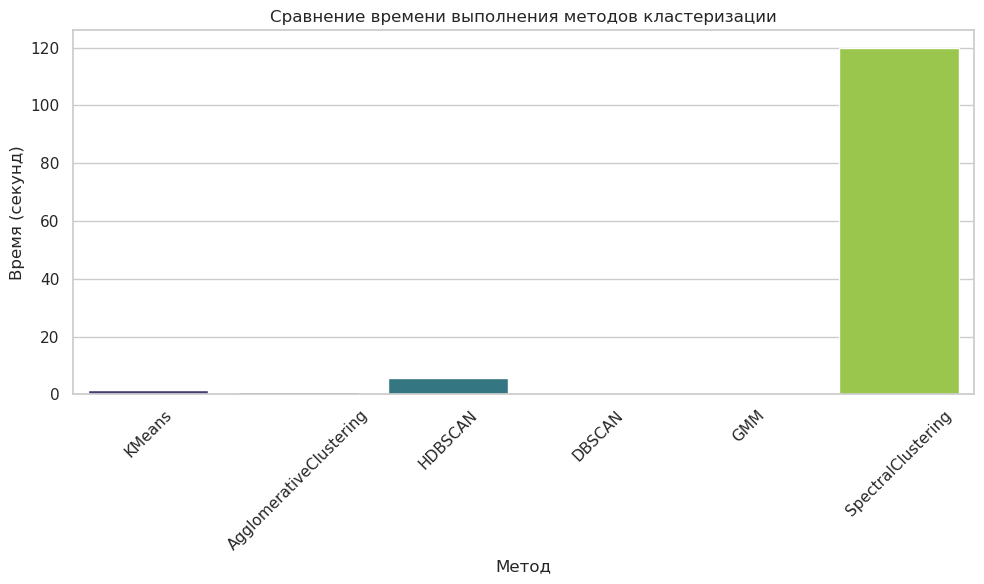

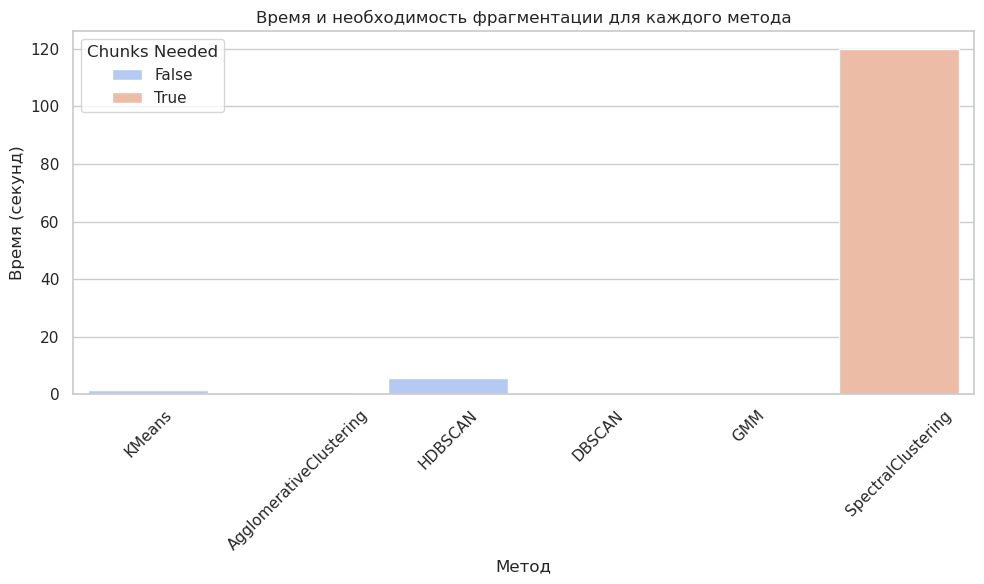

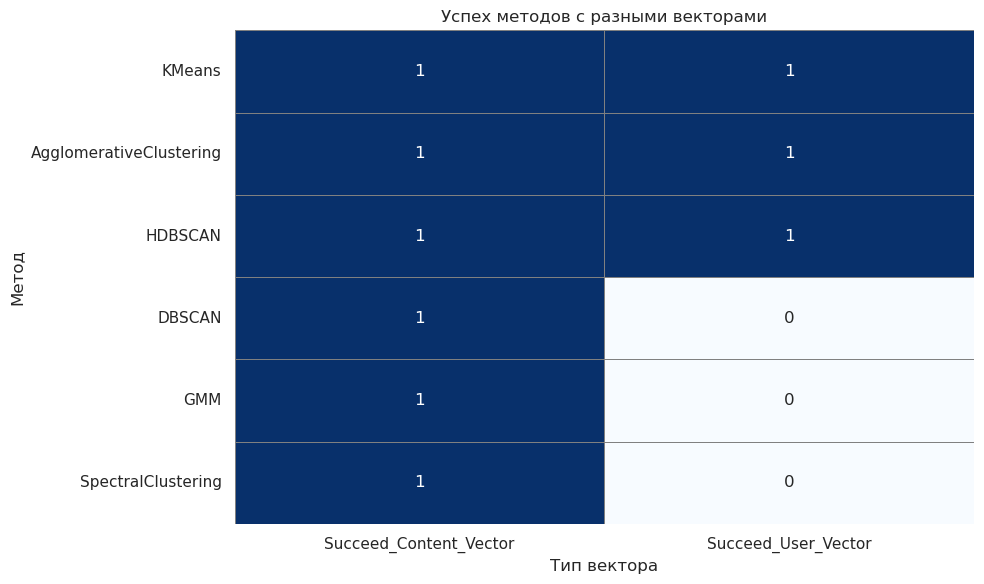

In [103]:
# Данные для визуализации
data = {
    'Method': ['KMeans', 'AgglomerativeClustering', 'HDBSCAN', 'DBSCAN', 'GMM', 'SpectralClustering'],
    'Succeed_Content_Vector': [True, True, True, True, True, True],
    'Succeed_User_Vector': [True, True, True, False, False, False],
    'Time_sec': [1.57, 0.97, 5.77, 0.05, 0.02, 120.00],
    'Chunks Needed': [False, True, False, False, False, True],
    'NumClusters': [50, 50, None, None, None, 50],
    'NoisePoints': [None, None, 'Almost all noise', 'Almost all noise', None, None],
    'Notes': [
        'Лучший по скорости и масштабируемости',
        'Хорошая иерархическая кластеризация',
        'Почти все данные — это шум',
        'Почти все данные — это шум',
        'Большие наборы не запускались',
        'Слишком медленно для больших наборов данных'
    ]
}

# Создаем DataFrame
df = pd.DataFrame(data)

# Настроим стиль визуализации
sns.set(style="whitegrid")

# График сравнения времени выполнения методов
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Time_sec', data=df, palette="viridis")
plt.title('Сравнение времени выполнения методов кластеризации')
plt.ylabel('Время (секунд)')
plt.xlabel('Метод')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Визуализация наличия чанкования
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Time_sec', hue='Chunks Needed', data=df, palette='coolwarm')
plt.title('Время и необходимость фрагментации для каждого метода')
plt.ylabel('Время (секунд)')
plt.xlabel('Метод')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap для успешности и проблемы кластеризации
heatmap_data = df[['Method', 'Succeed_Content_Vector', 'Succeed_User_Vector']].set_index('Method').astype(int)
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Успех методов с разными векторами')
plt.ylabel('Метод')
plt.xlabel('Тип вектора')
plt.tight_layout()
plt.show()